In [8]:
import pandas as pd
import random
from time import sleep
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import numpy as np
import nltk
import os
from sklearn import datasets
import pickle
from nltk.tokenize import word_tokenize
from sklearn.decomposition import NMF, TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neighbors import NearestNeighbors
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc, fbeta_score
from sklearn.model_selection import learning_curve, KFold, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import normalize
import re
from unidecode import unidecode

import matplotlib.style as style
%matplotlib inline
plt.style.use('ggplot')

In [9]:
with open('data/cleaned_df.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [10]:
df.head()

,song_owner,song_title,song_element,verse,artist
0,Childish Gambino,This Is America,[Bridge: Childish Gambino & Young Thug],"We just wanna party, Party just for you, We ju...",Childish Gambino
1,Childish Gambino,This Is America,[Chorus: Childish Gambino],"This is America, Don't catch you slippin' now,...",Childish Gambino
2,Childish Gambino,This Is America,"[Verse 1: Childish Gambino, Blocboy JB, Slim J...","This is America (skrrt, skrrt, woo), Don't cat...",Childish Gambino
3,Childish Gambino,This Is America,[Refrain: Choir & Childish Gambino],"Ooh-ooh-ooh-ooh-ooh, tell somebody, You go tel...",Childish Gambino
4,Childish Gambino,This Is America,"[Chorus: Childish Gambino, Slim Jxmmi & Young ...","This is America (woo, ayy), Don't catch you sl...",Childish Gambino


In [11]:
model_df = df.copy()

model_df = model_df[model_df['artist'] == 'Drake']

In [12]:
model_df['verse_words'] = model_df['verse'].copy()
model_df['verse_words'] = model_df['verse_words'].str.lower()
model_df['verse_words'] = model_df['verse_words'].apply(lambda x: x.replace(',',''))
model_df['verse_words'] = model_df['verse_words'].apply(lambda x: x.split(' '))

In [13]:
model_df.head()

,song_owner,song_title,song_element,verse,artist,verse_words
1282,Drake,Buried Alive (Interlude),[Intro],"If you was in a pine box, I would surely break...",Drake,"[if, you, was, in, a, pine, box, i, would, sur..."
1284,Drake,God's Plan,[Intro],"Yeah, they wishin' and wishin' and wishin' and...",Drake,"[yeah, they, wishin', and, wishin', and, wishi..."
1285,Drake,God's Plan,[Verse 1],"I been movin' calm, don't start no trouble wit...",Drake,"[i, been, movin', calm, don't, start, no, trou..."
1286,Drake,God's Plan,[Chorus 1],"God's plan, God's plan, I hold back, sometimes...",Drake,"[god's, plan, god's, plan, i, hold, back, some..."
1287,Drake,God's Plan,[Post-Chorus],"And still, bad things, It's a lot of bad thing...",Drake,"[and, still, bad, things, it's, a, lot, of, ba..."


In [14]:
from nltk.tokenize import word_tokenize
model_df['tokenize_verse'] = model_df['verse'].copy()
model_df['tokenize_verse'] = model_df['tokenize_verse'].str.lower()
model_df['tokenize_verse'] = model_df['tokenize_verse'].apply(lambda x: word_tokenize(x))

In [15]:
model_df['verse'] = model_df['verse'].str.lower()
model_df['verse'] = model_df['verse'].apply(lambda x: x.replace("'",''))
model_df['verse'] = model_df['verse'].apply(lambda x: "".join([c if c.isalnum() else " " for c in x ]))
model_df['verse'] = model_df['verse'].apply(lambda x: x.replace('  ',' '))

In [16]:
stopwords = ["yeah", "uh", "huh", "aw", "oh", "la", "ayy",
            "na", "ha", "ay", "skrrt",
            "em", "bla", "woo", "wu", "ya", "wala", "woop", "wrarrr", "ooh",
            "ba", "duh", "du", "1", "2", "3", "4" ,"5" ,"6", "7", "8", "9", "0"]

for index, row in model_df.iterrows():
    querywords = row['verse'].split()

    resultwords  = [word for word in querywords if word.lower() not in stopwords]
    row['verse'] = ' '.join(resultwords)

model_df.verse[:5]

1282    if you was in a pine box i would surely break ...
1284    they wishin and wishin and wishin and wishin t...
1285    i been movin calm dont start no trouble with m...
1286    gods plan gods plan i hold back sometimes i wo...
1287    and still bad things its a lot of bad things t...
Name: verse, dtype: object

In [17]:
verses = list(model_df.verse.values)

In [18]:
verses[:10]

['if you was in a pine box i would surely break the lock id jump right in and fall asleep cause you are the death of me if you was in a pine box i would surely break the lock id jump right in and fall asleep cause you are the death of me',
 'they wishin and wishin and wishin and wishin they wishin on me yuh',
 'i been movin calm dont start no trouble with me tryna keep it peaceful is a struggle for me dont pull up at am to cuddle with me you know how i like it when you lovin on me i dont wanna die for them to miss me yes i see the things that they wishin on me hope i got some brothers that outlive me they gon tell the story shit was different with me',
 'gods plan gods plan i hold back sometimes i wont yuh i feel good sometimes i dont dont i finessed down weston road nessed might go down a g o d wait i go hard on southside g yuh wait i make sure that north side eat',
 'and still bad things its a lot of bad things that they wishin and wishin and wishin and wishin they wishin on me bad t

In [19]:
all_verses_all_rappers = ','.join(verses)

all_verses_all_rappers[:100]

'if you was in a pine box i would surely break the lock id jump right in and fall asleep cause you ar'

In [20]:
file = all_verses_all_rappers

In [21]:
# Read in text and change unicode characters to ASCII
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file_len = len(file)
print(f'file_len = {file_len}')

file_len = 718122


In [22]:
chunk_len = 400

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

love why you wanna be my love my love my love why you wanna be my love my love my love why you wanna be my love my love my love why you wanna be my love my love my love,i had an idea in my head i pictured this going differently even when you sleep in my bed i know youre not mine officially and all the things i put a hold on all for you to hit me with a hold on what makes you so ready right now afte


In [23]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        output = self.encoder(input.view(1, -1))
        output, hidden = self.gru(output.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.randn(self.n_layers, 1, self.hidden_size))

In [24]:
def char2tensor(string):
    tensor = torch.zeros(len(string)).long()
    for char in range(len(string)):
        if string[char] in all_characters:
            tensor[char] = all_characters.index(string[char])
        else:
            tensor[char] = 94 #predict space if character unknown
        
    return Variable(tensor)

# Let's see it in action.
print(char2tensor('Metis0123abczABC'))

tensor([48, 14, 29, 18, 28,  0,  1,  2,  3, 10, 11, 12, 35, 36, 37, 38])


In [25]:
def random_training_set():
    chunk = random_chunk()
    inp = char2tensor(chunk[:-1])
    target = char2tensor(chunk[1:])
    return inp, target

In [26]:
def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):
    
    hidden = model.init_hidden()
    prime_input = char2tensor(prime_str)
    predicted = prime_str
    
    # use priming string to build up hidden state
    
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char2tensor(predicted_char)
        
    return predicted

In [27]:
# helper function
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

In [28]:
# The actual training part
def train(inp, target):
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0

    for char in range(chunk_len):
        output, hidden = model(inp[char], hidden)
        loss += criterion(output, target[char].unsqueeze(0))

    loss.backward()
    model_optimizer.step()

    return loss.data.item() / chunk_len

In [29]:
# parameters
n_epochs = 1000
print_every = 100
plot_every = 10
hidden_size = 256
n_layers = 2
learning_rate = 0.001

# model declaration
model = RNN(n_characters, hidden_size, n_characters, n_layers)
model_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate(model, 'A ', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 48s (100 10%) 2.1577]
A a i i nitrat you ke mo lyocdy wasintd ninfa wand it wallb ant i boun it ad it rom to to ment wath bi 

 39s (200 20%) 1.7190]
A canbow the on it arey hit on get the bothe it ne be buck danl was ty be be whey wite so m of sudy li 

 30s (300 30%) 1.9010]
A fiend up stiten my fro fake i young and ever and i like and a say gole then my the like los to dong  

 21s (400 40%) 1.6659]
A all loat how fire i me five takin stried reall i stlaw you gays i said nowin me and i fesce us lof o 

 12s (500 50%) 1.8853]
A it baggets now was the says shown it aint out band that im we to things to thinkine the srain to tha 

 3s (600 60%) 2.8959]
A its frine on change for me right your bruins now my get pot the could the way it just still fucking  

 53s (700 70%) 1.6143]
A a check plise and got got the came to me the con see in fick to dont try take my know moves a some a 

 44s (800 80%) 1.3658]
A harive i do up all i a like that your crich the suis like your worked the need r

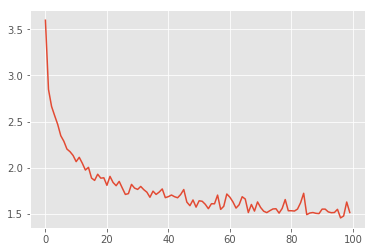

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [31]:
# Evaluate model from this notebook
print(evaluate(model, 'To be or not to be: ', predict_len=200, temperature=0.5))

To be or not to be: this is better for the really got a fuck though is the same it a like i want the i made all my started i got my trizzy it to more i cant my see a for man that see we better the started the controll th


In [32]:
# Evaluate model from this notebook
print(evaluate(model, 'I miss you girl come back ', predict_len=200, temperature=0.5))

I miss you girl come back this i dont know with you to me i stand i this thats say is my tryin down this we man money i dont tell to man my like i know what i better it with i like it we dont all i every make i want the paid i


In [47]:
# Evaluate model from this notebook
print(evaluate(model, "Started from the bottom", predict_len=200, temperature=0.4))

Started from the bottom my like we side i dont let my i dont talkin this with the way it started i like i have to the pressin all my go the fall my like the said my like i started the is tell the still i got the tryin the p


In [41]:
# Evaluate model from this notebook
print(evaluate(model, "I'm the realest rapper alive", predict_len=200, temperature=0.4))

I'm the realest rapper alive to have it for my time i m the shit im somethin this all the from the this i smill you wanna wont everythin i was and i know the more im time i dont be i cant started the time that to let my she way 


In [52]:
# Evaluate model from this notebook
print(evaluate(model, "Smoke a lot of weed", predict_len=200, temperature=0.4))

Smoke a lot of weed we dont tell to play i day to start i all the wanna say i like the base to still see the time i dont be and and my like a little the talkin i dont like the cant man to me i need i dont side i dont go


In [72]:
# Evaluate model from this notebook
print(evaluate(model, "Baby come", predict_len=200, temperature=0.4))

Baby come i still and i did that i do the same so i got we just wanna be and i m the song to start the to do i like i m this shit the like the better tried the say i see you started thats what i want you got a
